# Linear Regression (Multiple features)
We are going to use gradient descent and a learning rate to find the coefficients based on their partial derivative of the cost function.

The mental map goes like this: recall the cost function for a simple case (one X and one B), now there is multiple x's and multiple b's. Hence, we have to differentiate properly find the rate of change of the coefficients for each feature and instead of using the closed form to find the minimum, we will use the gradient desceng: b = old b - learning rate * rate of change of b

In [1]:
import os
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from app.pre_process import preprocess
from dotenv import load_dotenv


In [2]:
# engine = get_engine()
# data =  pd.read_sql("SELECT * FROM games", engine)
load_dotenv()
DATABASE_URL_LOCAL = os.getenv("DATABASE_URL_LOCAL")
data = preprocess(DATABASE_URL_LOCAL)
data.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,player_ppg,player_reb,player_ast,player_net_rating,opposite_team,opposite_team_Drtg,opposite_team_eFg_percent_defense,opposite_team_ft_fga_defense,opposite_team_pace,opposite_team_blk
0,20300039,1610612744,GSW,Golden State,461,Popeye Jones,None,None,None,1:22,...,2.0,2.3,0.3,-8.8,Philadelphia 76ers*,102.5,.263,16.2,91.4,3.5
1,20300040,1610612744,GSW,Golden State,461,Popeye Jones,None,None,None,0:06,...,2.0,2.3,0.3,-8.8,Los Angeles Lakers*,104.7,.228,13.4,92.5,5.7
2,20300556,1610612744,GSW,Golden State,461,Popeye Jones,None,None,None,1:26,...,2.0,2.3,0.3,-8.8,Cleveland Cavaliers,106.7,.223,13.0,94.0,6.4
3,20300668,1610612744,GSW,Golden State,461,Popeye Jones,None,None,None,3:41,...,2.0,2.3,0.3,-8.8,Chicago Bulls,105.6,.217,13.3,93.5,5.6
4,10300010,1610612752,NYK,New York,1720,Michael Doleac,None,None,None,5,...,4.4,2.9,0.6,-5.3,Washington Wizards,104.1,.253,13.8,88.2,4.8


So here let's have a feel for how the data is going to look for each player and whether a linear regression makes sense

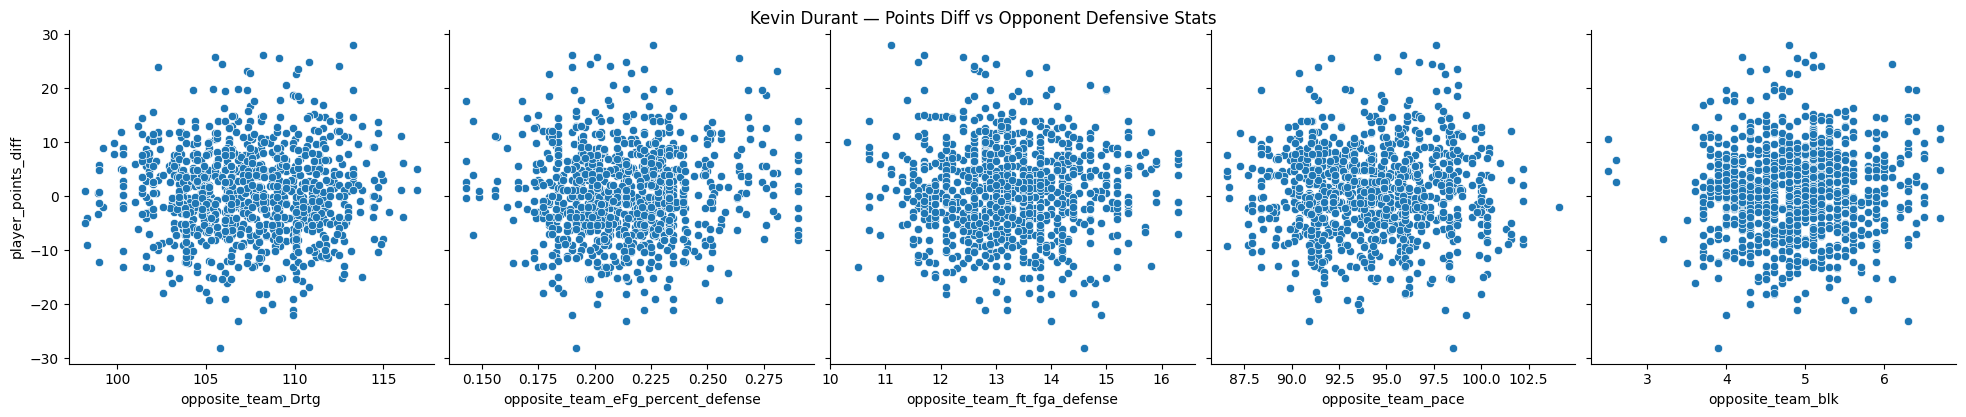

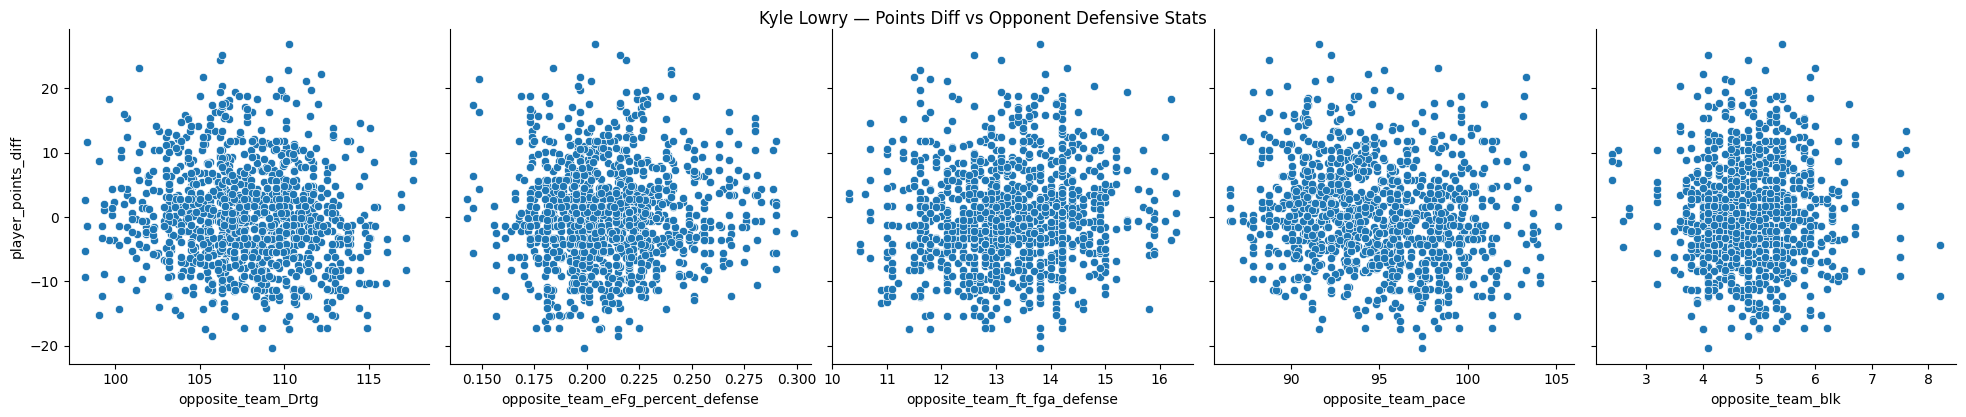

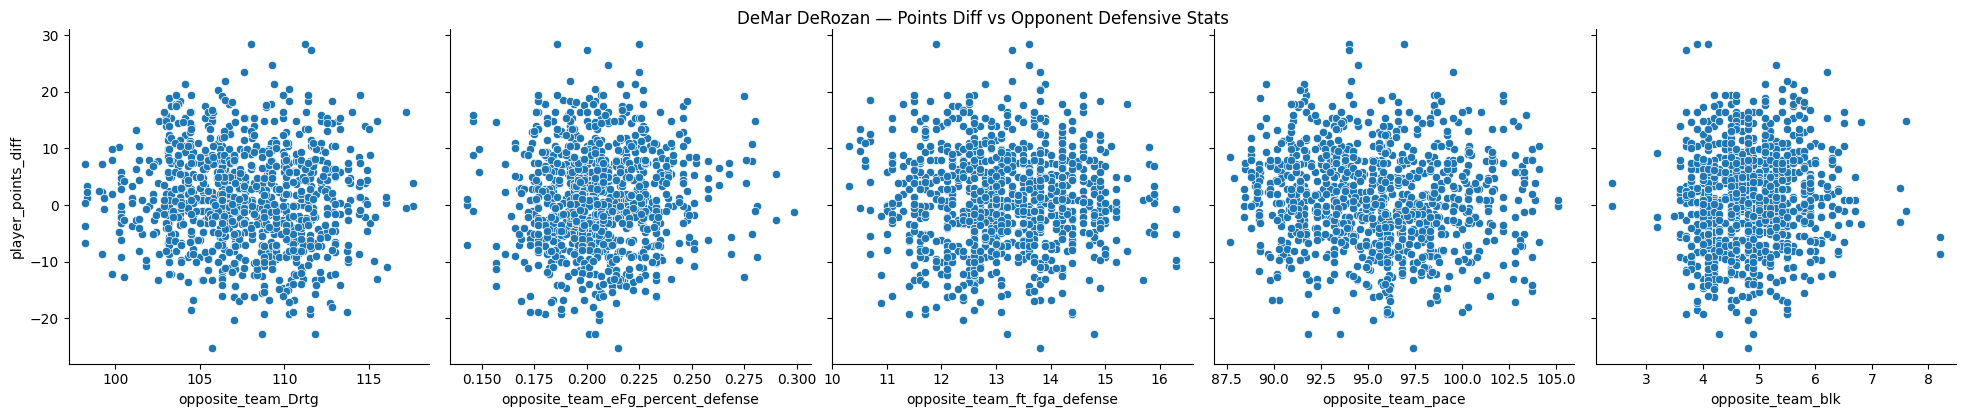

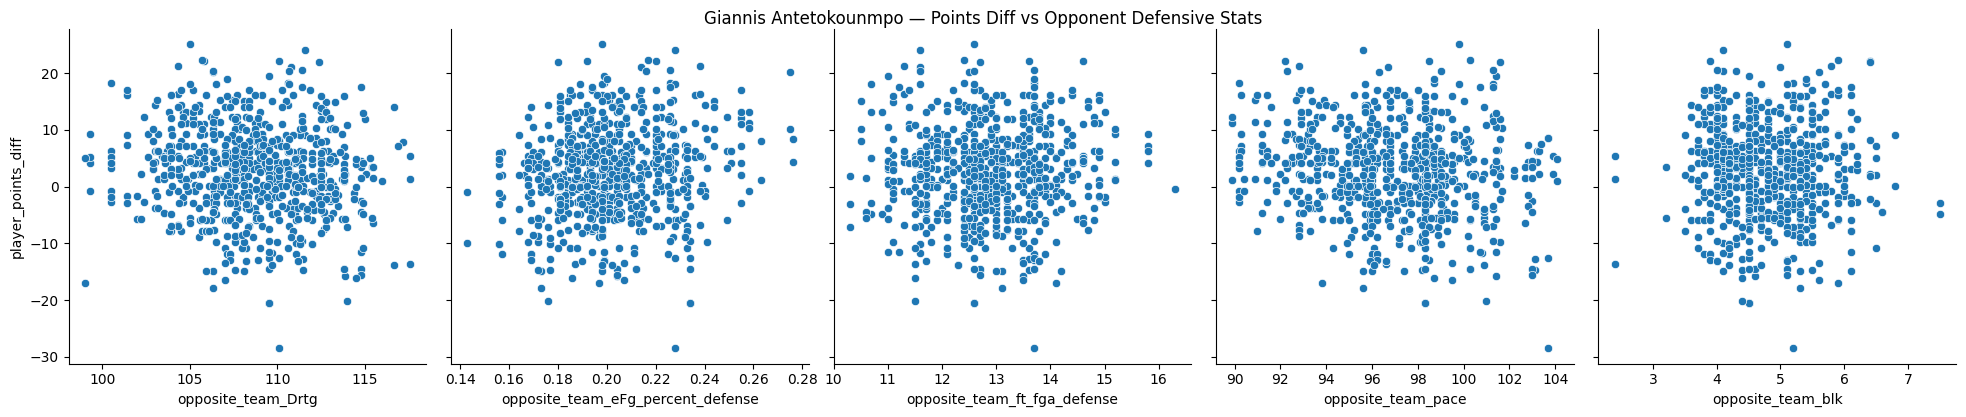

In [3]:
def plot_player_points_pairplot(df, player_name):
    
    # Filter player data
    player_df = df[df["PLAYER_NAME"] == player_name]

    # Select relevant columns
    cols = [
        "player_points_diff",
        "opposite_team_Drtg",
        "opposite_team_eFg_percent_defense",
        "opposite_team_ft_fga_defense",
        "opposite_team_pace",
        "opposite_team_blk"
    ]
    plot_df = player_df[cols].astype(float)

    # Pairplot
    sns.pairplot(plot_df, y_vars=["player_points_diff"],
                 x_vars=cols[1:],
                 kind='scatter', height=4, aspect=1)
    plt.suptitle(f"{player_name} — Points Diff vs Opponent Defensive Stats", y=1.02)
    plt.show()

# Example usage
plot_player_points_pairplot(data, "Kevin Durant")
plot_player_points_pairplot(data, "Kyle Lowry")
plot_player_points_pairplot(data, "DeMar DeRozan")
plot_player_points_pairplot(data, "Giannis Antetokounmpo")

# Training

Now that we have the preprocessed data, we can train models for specific players (more than 100 games, players that don't have a model will be matched to a player with similar stats that do have a model)

In [4]:
def gradient_descent_multi(X, y, w_init=None, b_init=0, learning_rate=0.01, epochs=1000, tolerance=1e-6):
    N, d = X.shape
    w = np.zeros(d) if w_init is None else w_init
    b = b_init

    for _ in range(epochs):
        y_pred = X @ w + b
        error = y - y_pred

        # Gradients
        w_gradient = -(2/N) * (X.T @ error)
        b_gradient = -(2/N) * np.sum(error)

        # Update
        new_w = w - learning_rate * w_gradient
        new_b = b - learning_rate * b_gradient

        # Tolerance check
        if np.all(np.abs(new_w - w) < tolerance) and abs(new_b - b) < tolerance:
            break

        w, b = new_w, new_b

    return w, b

Weights: [-0.5855561  -0.01991918  0.44611003  0.06539114 -0.13576021]
Bias: 1.1100518320055606


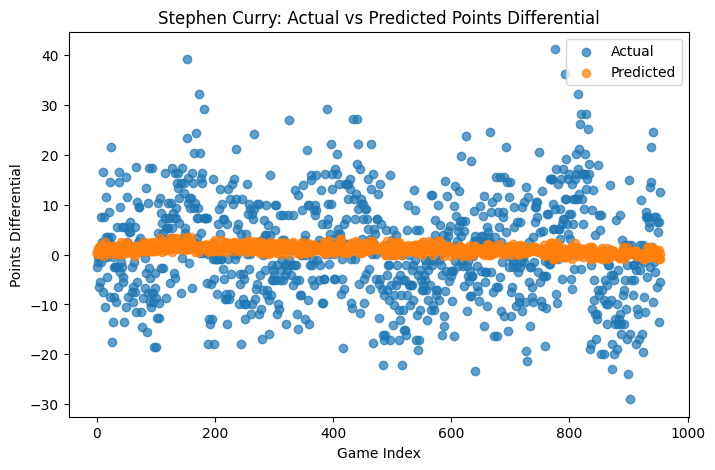

In [12]:
player_name = "Stephen Curry"
# 1️⃣ Filter Kevin Durant's data
player_df = data[data["PLAYER_NAME"] == player_name]

# 2️⃣ Select features (X) and target (y)
# Features
features = [
    "opposite_team_Drtg",
    "opposite_team_eFg_percent_defense",
    "opposite_team_ft_fga_defense",
    "opposite_team_pace",
    "opposite_team_blk"
]
X_raw = player_df[features].values.astype(float)
y = player_df["player_points_diff"].values.astype(float)

# Standardize X, x_standard = (x - mean)/stddev
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# 3️⃣ Train using your gradient descent
w, b = gradient_descent_multi(X, y, learning_rate=0.01, epochs=5000, tolerance=1e-5)

# 4️⃣ Print results
print("Weights:", w)
print("Bias:", b)

# 5️⃣ Optional: check predictions
y_pred = X @ w + b

plt.figure(figsize=(8,5))
plt.scatter(range(len(y)), y, label="Actual", alpha=0.7)
plt.scatter(range(len(y)), y_pred, label="Predicted", alpha=0.7)
plt.xlabel("Game Index")
plt.ylabel("Points Differential")
plt.title(player_name + ": Actual vs Predicted Points Differential")
plt.legend()
plt.show()

# Performance Evaluation


MAE = Mean Absolute Error = mean of the sum of the differences between predicted points and actual points in game index x
RMSE = Root Mean Square Error = root of the mean of the squared sum of the differences between predicted points and actual points in game indexed x
R^2 = Coefficient of Determination = squared of correlation = how strong is the relationship between the features and the output

In [13]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)          # residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) # total sum of squares
    return 1 - (ss_res / ss_tot)

In [14]:
print("MAE:", mae(y, y_pred))
print("RMSE:", rmse(y, y_pred))
print("R²:", r2(y, y_pred))

MAE: 8.136747726261213
RMSE: 10.167474825738005
R²: 0.0063667520148814605


## Comparison between model from scratch and model from scikit learn